In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os
import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
sys.argv = ['-f', 'ctdet', '--exp_id', 'coco_dlav7','--num_workers', '0','--batch_size','2', '--arch','dlav6_34'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdet\coco_dlav7
ctdet
0
2


In [18]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [19]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'hm': 80, 'wh': 2, 'reg': 2}


In [20]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [21]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [22]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=20.14s)
creating index...
index created!
Loaded train 118287 samples


In [23]:
img = next(iter(train_loader))

In [24]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'hm_mod', 'reg'])
torch.Size([2, 3, 512, 512])


In [28]:
img['hm_mod'].shape[1]

128

In [26]:
model.to('cuda')
torch.cuda.empty_cache()
outputs = model(img['input'].to('cuda'))
output = outputs[0]
print(output.keys())

dict_keys(['objns', 'hm', 'wh', 'reg'])


In [11]:
batch=img
mask = batch['reg_mask']
ind = batch['ind']
target_wh = batch['wh']
target_reg = batch['reg']

In [12]:
pred_hm = output['hm'].sigmoid()
print(pred_hm.size())
gt_hm = batch['hm']
print(gt_hm.size())

torch.Size([2, 80, 128, 128])
torch.Size([2, 80, 128, 128])


In [13]:
#80C Heatmap pred vs 80C heatmap gt
pos_inds = gt_hm.eq(1)
neg_inds = gt_hm.lt(1)
print(pos_inds.float().sum())
print(neg_inds.float().sum())
neg_weights = torch.pow(1 - gt_hm[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = pred_hm[pos_inds].to('cuda')
neg_pred = pred_hm[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

tensor(11.)
tensor(2621429.)
torch.Size([2621429])
torch.Size([2621429])
torch.Size([2621429])
tensor(11.)
tensor(-22.6171, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3031.7805, device='cuda:0', grad_fn=<SumBackward0>)
tensor(277.6725, device='cuda:0', grad_fn=<RsubBackward1>)


In [14]:
#80C Heatmap gt vs 80C heatmap gt
pos_inds = gt_hm.eq(1)
neg_inds = gt_hm.lt(1)
print(pos_inds.float().sum())
print(neg_inds.float().sum())
neg_weights = torch.pow(1 - gt_hm[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = gt_hm[pos_inds].to('cuda')
neg_pred = gt_hm[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

tensor(11.)
tensor(2621429.)
torch.Size([2621429])
torch.Size([2621429])
torch.Size([2621429])
tensor(11.)
tensor(0., device='cuda:0')
tensor(-3.8679, device='cuda:0')
tensor(0.3516, device='cuda:0')


In [44]:
##1 Heatmap gt vs 80C heatmap gt sumdim 1
hm_1c = img['hm_mod'] #gt 1heatmap
gt_hm2 = gt_hm.sum(1)/gt_hm.max() #gt 80c to 1c sum

pos_inds = gt_hm2.eq(1)
neg_inds = gt_hm2.lt(1)
print(pos_inds.float().sum())
print(neg_inds.float().sum())
neg_weights = torch.pow(1 - gt_hm2[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = hm_1c[pos_inds].to('cuda')
neg_pred = hm_1c[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

tensor(11.)
tensor(32757.)
torch.Size([32757])
torch.Size([32757])
torch.Size([32757])
tensor(11.)
tensor(0., device='cuda:0')
tensor(-3.8679, device='cuda:0')
tensor(0.3516, device='cuda:0')


In [16]:
##80C Heatmap pred to 1C vs 80C heatmap gt sumdim 1
hm_1c = img['hm_mod'] #gt 1heatmap
pred_hm2 = pred_hm[:,0,:,:] #gt 80c to 1c sum

pos_inds = gt_hm2.eq(1)
neg_inds = gt_hm2.lt(1)
print(pos_inds.float().sum())
print(neg_inds.float().sum())
neg_weights = torch.pow(1 - gt_hm2[neg_inds], 4).to('cuda')
print(neg_weights.size())

loss = 0
pos_pred = pred_hm2[pos_inds].to('cuda')
neg_pred = pred_hm2[neg_inds].to('cuda')
print(neg_pred.size())

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights
print(neg_loss.size())

num_pos  = pos_inds.float().sum()
print(num_pos)
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print(pos_loss)
print(neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print(loss)

tensor(11.)
tensor(32757.)
torch.Size([32757])
torch.Size([32757])
torch.Size([32757])
tensor(11.)
tensor(-24.0373, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-25.6394, device='cuda:0', grad_fn=<SumBackward0>)
tensor(4.5161, device='cuda:0', grad_fn=<RsubBackward1>)


C heatmaps summed
torch.Size([2, 128, 128])
tensor(0.1531, device='cuda:0', grad_fn=<MaxBackward1>)


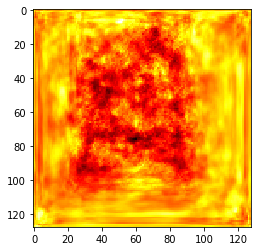

In [17]:
print('C heatmaps summed')
img_gt2 = pred_hm2.detach().cpu().numpy()
print(pred_hm2.size())
print(pred_hm2.max())
plt.imshow(img_gt2[0], cmap='hot', interpolation='nearest')

C heatmaps summed
torch.Size([2, 128, 128])
tensor(0.1073, device='cuda:0', grad_fn=<MaxBackward1>)


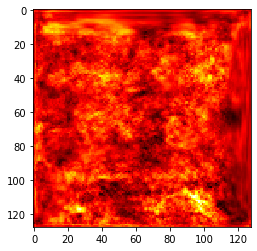

In [18]:
print('C heatmaps summed')
pred2 = pred_hm.sum(1)/80
print(pred2.size())
print(pred2.max())
img_gt3 = pred2.detach().cpu().numpy()
plt.imshow(img_gt3[1], cmap='hot', interpolation='nearest')

In [34]:
##80C Heatmap pred to 1C vs 80C heatmap gt sumdim 1 v2
hm_1c = img['hm_mod'] #gt 1heatmap
pred2 = pred_hm.sum(1)/80
print(pred2.size())
print(pred2.max())
pos_inds = gt_hm2.eq(1)
neg_inds = gt_hm2.lt(1)
print('pos:',pos_inds.float().sum())
print('neg:',neg_inds.float().sum())
neg_weights = torch.pow(1 - gt_hm2[neg_inds], 4).to('cuda')

loss = 0
pos_pred = pred2[pos_inds].to('cuda')
neg_pred = pred2[neg_inds].to('cuda')

pos_loss = torch.log(pos_pred) * torch.pow(1 - pos_pred, 2)
neg_loss = torch.log(1 - neg_pred) * torch.pow(neg_pred, 2) * neg_weights

num_pos  = pos_inds.float().sum()
pos_loss = pos_loss.sum()
neg_loss = neg_loss.sum()
print('neg_loss:',neg_loss)
if pos_pred.nelement() == 0:
    loss = loss - neg_loss
else:
    loss = loss - (pos_loss + neg_loss) / num_pos
print('loss: ',loss)

torch.Size([2, 128, 128])
tensor(0.1073, device='cuda:0', grad_fn=<MaxBackward1>)
pos: tensor(11.)
neg: tensor(32757.)
neg_loss: tensor(-35.1225, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(5.0378, device='cuda:0', grad_fn=<RsubBackward1>)


C heatmaps summed


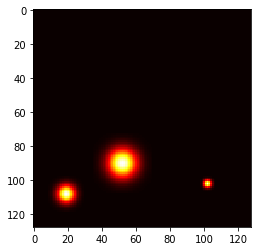

In [20]:
print('C heatmaps summed')
plt.imshow(hm_1c.detach().cpu().numpy()[1], cmap='hot', interpolation='nearest')

Prueba de Circlenet_loss

In [30]:
import torch.nn.functional as F

In [38]:
import torch.nn as nn

In [55]:
class QualityFocalLoss(nn.Module):
    '''Quality Focal Loss. Use logits to improve numerical stability. Generalized Focal Loss: https://arxiv.org/abs/2006.04388
    '''
    def __init__(self, beta: float = 2, reduction: str = 'sum'):
        '''Quality Focal Loss. Default values are from the paper
        Args:
            beta: control the scaling/modulating factor to reduce the impact of easy examples
            reduction: either none, sum, or mean 
        '''
        super().__init__()
        assert reduction in ('none', 'sum', 'mean')
        self.beta = beta
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(inputs)

        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        modulating_factor = torch.pow(torch.abs(targets - probs), self.beta)
        
        loss = modulating_factor * ce_loss
        if self.reduction == 'none':
            return loss

        loss = torch.sum(loss)
        if self.reduction == 'mean':
            loss = loss / targets.eq(1).float().sum()

        return loss

In [52]:
##80C Heatmap pred to 1C vs 80C heatmap gt sumdim 1 v2
#pred_hm = output['hm'].sigmoid()
hm_1c = img['hm_mod'] #gt 1heatmap torch.Size([2, 128, 128])
pred = output['hm'][:,0,:,:] #torch.Size([2, 128, 128])
inputs = pred.clone().to('cuda')    #torch.Size([2, 128, 128])
targets = hm_1c.clone().to('cuda')  #torch.Size([2, 128, 128])

loss = QualityFocalLoss()
print(loss(inputs, targets))

tensor(240.7056, device='cuda:0', grad_fn=<SumBackward0>)


In [51]:
hm_1c = img['hm_mod'] #gt 1heatmap
gt_hm2 = gt_hm.sum(1)/gt_hm.max() #gt 80c to 1c sum
inputs = hm_1c.clone().to('cuda')    #torch.Size([2, 128, 128])
targets = gt_hm2.clone().to('cuda')  #torch.Size([2, 128, 128])

loss = QualityFocalLoss()
print(loss(inputs, targets))

tensor(5581.1318, device='cuda:0')


In [58]:
inputs = gt_hm.clone().to('cuda')    #torch.Size([2, 128, 128])
targets = gt_hm.clone().to('cuda')  #torch.Size([2, 128, 128])

loss = QualityFocalLoss(reduction = 'mean')
print(loss(inputs, targets))

tensor(41287.6211, device='cuda:0')
